#### Urban Resilience Metrics Identification - Part 2

**Introduction**

Building on our initial exploration in Part 1, this notebook takes a more comprehensive approach towards the identification of urban resilience metrics. In this part, we focus on analyzing the frequency of terms across multiple city resilience reports, allowing us to draw broader conclusions about the emphasis on various resilience factors across different urban environments.

**Notebook methodology involves**:
1. Referencing Terms_Overview.xlsx to extract terms of interest.
2. Cross-referencing these terms with the resilience report URLs provided in 100RC_DataCollection.xlsx for all cities.
3. Employing SpaCy / Direct String Matching for in-depth term frequency analysis across the reports.
4. Storing term frequencies / phrases for each city in individual CSV files. (Both Spacy / Direct String Matching)
5. Aggregating these frequencies across cities into a single CSV for a comprehensive view.
6. Conducting TF-IDF to see for term importance across all documents.

**Using Part 2**:

Leveraging libraries such as PyPDF2 for PDF extraction, nltk for text processing, and spacy for term frequency analysis, this notebook systematically works through the resilience reports of various cities. It processes and analyzes the content, ultimately providing aggregated insights into term frequencies and their importance.

Note: Initially, we gathered 95 cities as a data collection to 100RC_DataCollection whom participated in 100RC campaign. For data analysis reasons, we've narrowed it down to 77 cities, eliminating cities from the list who 1. Do not have resilience report 2. Scripted in different language 3. Crashed pdf file. The alienated cities are marked by **red** under 100RC_DataCollection.xlsx file.  

By _Josh Jeon_

In [1]:
#Library Install
!pip install -q PyPDF2 requests nltk spacy textblob gensim matplotlib seaborn wordcloud geopandas bert-extractive-summarizer
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
#Library Load
import pandas as pd  # Library for data manipulation
import spacy  # Library for Natural Language Processing 
import nltk  # Natural Language Toolkit
import requests  # HTTP requests to fetch web content
from PyPDF2 import PdfReader  # extract text from PDF files
from nltk.tokenize import word_tokenize, sent_tokenize  # Tokenizes text into words and sentences
from nltk.corpus import stopwords  # list of stopwords in various languages
from nltk.stem import WordNetLemmatizer  # Lemmatizes words 
from sklearn.preprocessing import MinMaxScaler  # Scales data to a specified range
import string  # Contains common string operations and properties 
import matplotlib.pyplot as plt  # Library for data visualization
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF features

# Spacy Model Load - en_core_web_sm
nlp = spacy.load('en_core_web_sm')


In [3]:
#DATA LOAD
#Load the resilience report and terms to check.
Resilience_Collection = pd.read_excel('100RC_DataCollection.xlsx')

#Load a list of terms to check
terms_df = pd.read_excel('Terms_Overview.xlsx')
all_terms = terms_df.values.flatten() #One Dimension
all_terms = [term.strip().lower() for term in all_terms 
             if isinstance(term, str)]  #Excludes strings that are empty after stripping


In [4]:
#DIRECTORY SAVE
# Directories to save the PDF and text reports, and summaries.
pdf_directory = "D:/Graduate School/Experience Expo/Code/Report PDF/"
text_directory = "D:/Graduate School/Experience Expo/Code/Report Text/"
summary_directory = "D:/Graduate School/Experience Expo/Code/Report Summary/"


In [5]:
# PDF EXTRACTION

def download_and_extract_text(url, city_name):
    
    """
    Download PDF from URL, extract text, and save the text to a file.

    Parameters:
    - url (str): The URL of the PDF.
    - output_pdf_file (str): The name of the file to save the downloaded PDF.
    - output_text_file (str): The name of the file to save the extracted text.
    
    Returns:
    - str: The extracted text from the PDF.
    """
    
    #Define paths for the PDF and text files
    output_pdf_file = f"{pdf_directory}{city_name}-Resilience-Strategy-English.pdf"
    output_text_file = f"{text_directory}{city_name}-Resilience-Strategy-English.txt"
        
    #Download the PDF file from the provided URL
    response = requests.get(url)
    with open(output_pdf_file, 'wb') as f:
        f.write(response.content)

    text = ''
    
    #Extract text from the downloaded PDF
    try:
        with open(output_pdf_file, 'rb') as f:
            reader = PdfReader(f)
            for page in reader.pages:
                text += page.extract_text()
    
    except Exception as e:
        print(f"Error reading PDF for city {city_name}. Error: {e}")
        return None

    #Save the extracted text to a file
    with open(output_text_file, 'w', encoding='utf-8') as f:
        f.write(text)
    return text

In [6]:
#PREPROCESSING
#Download NLTK Data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):
    
    """
    Preprocess the given text by tokenizing, removing stopwords, and lemmatizing.

    Parameters:
    - text (str): The text to preprocess.
    
    Returns:
    - list: The preprocessed sentences.
    """
    
    lemmatizer = WordNetLemmatizer() #Word Lemmatization
    
    stop_words = set(stopwords.words('english')) #English stop words
    
    sentences = sent_tokenize(text) #Tokenizing text into sentences
    
    preprocessed_sentences = [] #Dictionary to hold preprocessed sentence
    
    #Preprocess each sentence
    for sentence in sentences:
        sentence = sentence.translate(str.maketrans('', '', string.punctuation)).lower()
        words = word_tokenize(sentence)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        preprocessed_sentences.append(' '.join(words))

    return preprocessed_sentences


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lifet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lifet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lifet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lifet\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
#TERM EXTRACTION 

def direct_string_matching(terms, text):
    
    """
    Match terms in the text using direct string matching.

    Parameters:
    - terms (list): The terms to check.
    - text (str): The text to check for terms.
    
    Returns:
    - list: The terms and their frequencies in the text.
    """
    
    # Tokenize the text
    tokens = word_tokenize(text)

    # Count occurrences of each term in the tokenized text
    term_frequencies = {term: tokens.count(term) for term in terms}
    return sorted(term_frequencies.items(), key=lambda x: x[1], reverse=True)

def spacy_matching(terms, text):
    
    """
    Match terms in the given text using SpaCy.

    Parameters:
    - terms (list): The terms to check.
    - text (str): The text to check for terms.
    
    Returns:
    - list: The terms and their frequencies in the text.
    """
    
    doc = nlp(text)
    tokens = [token.text for token in doc]
    term_frequencies = {term: tokens.count(term) for term in terms}
    return sorted(term_frequencies.items(), key=lambda x: x[1], reverse=True)

def extract_term_frequencies(terms, preprocessed_sentences):
    term_frequencies = {}
    term_phrases = {}
    
    for term in terms:
        term_frequencies[term] = sum([sentence.count(term) for sentence in preprocessed_sentences])
        term_phrases[term] = [sentence for sentence in preprocessed_sentences if term in sentence]
    return term_frequencies, term_phrases



In [8]:
# SAVING RESULTS 
def save_terms_to_csv(spacy_freqs, direct_freqs, term_phrases, freq_filename_spacy="spacy_term_frequencies.csv", freq_filename_direct="direct_term_frequencies.csv", phrases_filename="term_phrases.csv"):
    
    """
    Save term frequencies and the sentences in which they appear to CSV files.

    Parameters:
    - term_frequencies (dict): The term frequencies.
    - term_phrases (dict): The sentences in which the terms appear.
    - freq_filename (str, optional): The filename for the term frequencies. Defaults to "term_frequencies.csv".
    - phrases_filename (str, optional): The filename for the term phrases. Defaults to "term_phrases.csv".
    
    Returns:
    - tuple: The paths of the saved CSV files for term frequencies and term phrases.
    """
    
    freq_path = "D:/Graduate School/Experience Expo/Code/City Frequency/"
    phrases_path = "D:/Graduate School/Experience Expo/Code/City Frequency Phrases/"
    
    # Paths for the CSV files
    freq_file_path_spacy = freq_path + freq_filename_spacy
    freq_file_path_direct = freq_path + freq_filename_direct
    phrases_file_path = phrases_path + phrases_filename

    # Creating DataFrames for the frequencies and phrases
    df_spacy_frequencies = pd.DataFrame({
        'Term': list(spacy_freqs.keys()),
        'Frequency': list(spacy_freqs.values())
    })

    df_direct_frequencies = pd.DataFrame({
        'Term': list(direct_freqs.keys()),
        'Frequency': list(direct_freqs.values())
    })

    df_term_phrases = pd.DataFrame({
        'Term': list(term_phrases.keys()),
        'Sentences': [", ".join(term_phrases[term]) for term in term_phrases.keys()]
    })

    # Saving the DataFrames to CSV
    df_spacy_frequencies.to_csv(freq_file_path_spacy, index=False)
    df_direct_frequencies.to_csv(freq_file_path_direct, index=False)
    df_term_phrases.to_csv(phrases_file_path, index=False)

    return freq_file_path_spacy, freq_file_path_direct, phrases_file_path



In [9]:
#FREQUENCY / PHRASE EXTRACTION
# Process for loop to run city and its url
terms_dict = {}

for index, row in Resilience_Collection.iterrows():
    city_name = row['City']
    url = row['Source']

    #Download and extract text for the city
    text = download_and_extract_text(url, city_name)
    
    #Check if text extraction was successful
    if text is None:
        print(f"Failed to extract or read PDF for city: {city_name}. Skipping...")
        continue                    

    #Preprocess the text
    preprocessed_text = preprocess_text(text)
    preprocessed_text_str = ' '.join(preprocessed_text)  # Joining preprocessed sentences

    # Check for non-empty preprocessed text
    if not preprocessed_text_str or preprocessed_text_str.strip() == "":
        print(f"Failed to preprocess text for city: {city_name}. Skipping...")
        continue

    # Extract term frequencies using direct_results
    direct_results = direct_string_matching(all_terms, preprocessed_text_str)
    
    # Check before spacy matching
    if not preprocessed_text_str or preprocessed_text_str.strip() == "":
        print(f"Invalid input for SpaCy matching for city: {city_name}. Skipping...")
        continue
    
    #Extract term frequencies using spacy_results
    spacy_results = spacy_matching(all_terms, preprocessed_text_str)
    
    # Save the results to CSV - Saves spacy_results, direct_results, phrases
    save_terms_to_csv(
        {term: freq for term, freq in spacy_results}, 
        {term: freq for term, freq in direct_results},
        {term: [sentence for sentence in preprocessed_text if term in sentence] for term, freq in direct_results},
        freq_filename_spacy=f"{city_name}_spacy_frequencies.csv",
        freq_filename_direct=f"{city_name}_direct_frequencies.csv",
        phrases_filename=f"{city_name}_phrases.csv"
    )



unknown widths : 
[0, IndirectObject(14889, 0, 2783025004608)]
unknown widths : 
[0, IndirectObject(14893, 0, 2783025004608)]
unknown widths : 
[0, IndirectObject(14897, 0, 2783025004608)]
unknown widths : 
[0, IndirectObject(14901, 0, 2783025004608)]
unknown widths : 
[0, IndirectObject(14905, 0, 2783025004608)]
unknown widths : 
[0, IndirectObject(14909, 0, 2783025004608)]


In [12]:
#Reloading dataset with terms under different parameter
terms_df = pd.read_excel('Terms_Overview.xlsx')
terms_dict = {}

for column in terms_df.columns:
    main_term = column
    sub_terms = [term.strip().lower() 
                for term in terms_df[column].dropna().tolist() 
                if term.strip()]

    terms_dict[main_term] = sub_terms

In [14]:
#AGGREGATION OF FREQUENCIES
from collections import defaultdict

# Empty DataFrame to store results
result_df = pd.DataFrame(columns=['City'] + list(terms_dict.keys()))

# For Loop to process each city with its URL
for index, row in Resilience_Collection.iterrows():
    city_name = row['City']
    url = row['Source']
    
    # Download and extract text for the city
    text = download_and_extract_text(url, city_name)
    if text is None:
        print(f"Failed to extract or read PDF for city: {city_name}. Skipping...")
        continue
    
    # Preprocess the text
    preprocessed_text = preprocess_text(text)
    preprocessed_text_str = ' '.join(preprocessed_text)

    # Check for non-empty preprocessed text
    if not preprocessed_text_str or preprocessed_text_str.strip() == "":
        print(f"Failed to preprocess text for city: {city_name}. Skipping...")
        continue

    # Adding frequencies
    aggregated_freqs = defaultdict(int)
    for main_term, sub_terms in terms_dict.items():
        frequencies = spacy_matching(sub_terms, preprocessed_text_str)
        total_freq = sum([freq for term, freq in frequencies])  # summing the frequencies from the tuples
        aggregated_freqs[main_term] = total_freq

    # Update the result DataFrame
    result_df = result_df.append({
        'City': city_name,
        **aggregated_freqs
    }, ignore_index=True)

# Save the result DataFrame to CSV
csv_path = "Aggregated_Normalized_Frequencies.csv"
result_df.to_csv(csv_path, index=False)


C:\Users\lifet\AppData\Local\Temp\ipykernel_23880\709998919.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
C:\Users\lifet\AppData\Local\Temp\ipykernel_23880\709998919.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
unknown widths : 
[0, IndirectObject(14889, 0, 2781142311216)]
unknown widths : 
[0, IndirectObject(14893, 0, 2781142311216)]
unknown widths : 
[0, IndirectObject(14897, 0, 2781142311216)]
unknown widths : 
[0, IndirectObject(14901, 0, 2781142311216)]
unknown widths : 
[0, IndirectObject(14905, 0, 2781142311216)]
unknown widths : 
[0, IndirectObject(14909, 0, 2781142311216)]
C:\Users\lifet\AppData\Local\Temp\ipykernel_23880\709998919.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

In [15]:
#NORMALIZE USING QUANTILE

def normalize_using_quantiles(input_path: str, output_path: str):
    """
    Normalize city resilience data using quantiles.
    
    Parameters:
    - input_path: Path to the input CSV file.
    - output_path: Path to save the normalized CSV file.
    """
    # Read the data
    data = pd.read_csv(input_path)
    
    cities = data['City']
    data.drop('City', axis=1, inplace=True)

    # Normalize data using quantiles in a scale of 1-5
    quantile_labels = [1, 2, 3, 4, 5]
    data_normalized = pd.DataFrame()

    for column in data.columns:
        data_normalized[column] = pd.qcut(data[column].rank(method='first'), q=5, labels=quantile_labels)

    # Add back the 'City' column
    data_normalized['City'] = cities
    data_normalized = data_normalized[['City'] + [col for col in data_normalized.columns if col != 'City']]
    
    # Save the normalized data
    data_normalized.to_csv(output_path, index=False)

input_file = "Aggregated_Normalized_Frequencies.csv"
output_file = "Quantile_Normalized_Frequencies.csv"
normalize_using_quantiles(input_file, output_file)


In [16]:
#TF-IDF DOCUMENT

all_documents = [] # List for all documents
processed_cities = []  # List to track cities for which documents were successfully processed

for index, row in Resilience_Collection.iterrows():
    city_name = row['City']
    url = row['Source']
    
    # Ensure city_name is a string
    if not isinstance(city_name, str):
        print(f"City name is not a string for index {index}. Skipping...")
        continue
    
    text = download_and_extract_text(url, city_name)
    
    # Ensure text is a string
    if not isinstance(text, str):
        print(f"Text extraction failed or did not return a string for city: {city_name}. Skipping...")
        continue
    
    preprocessed_text = preprocess_text(text)
    all_documents.append(' '.join(preprocessed_text))
    processed_cities.append(city_name)  # Append the city to the list of processed cities

all_terms = list(set([term for sublist in terms_dict.values() for term in sublist]))

vectorizer = TfidfVectorizer(vocabulary=all_terms)
tfidf_matrix = vectorizer.fit_transform(all_documents)

# Now, tfidf_matrix contains the TF-IDF scores for each term in each document
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Add city names to the DataFrame
tfidf_df['City'] = processed_cities  # Use the list of processed cities instead

csv_path = "TFIDF_Scores.csv"
tfidf_df.to_csv(csv_path, index=False)


unknown widths : 
[0, IndirectObject(14889, 0, 2781136279392)]
unknown widths : 
[0, IndirectObject(14893, 0, 2781136279392)]
unknown widths : 
[0, IndirectObject(14897, 0, 2781136279392)]
unknown widths : 
[0, IndirectObject(14901, 0, 2781136279392)]
unknown widths : 
[0, IndirectObject(14905, 0, 2781136279392)]
unknown widths : 
[0, IndirectObject(14909, 0, 2781136279392)]


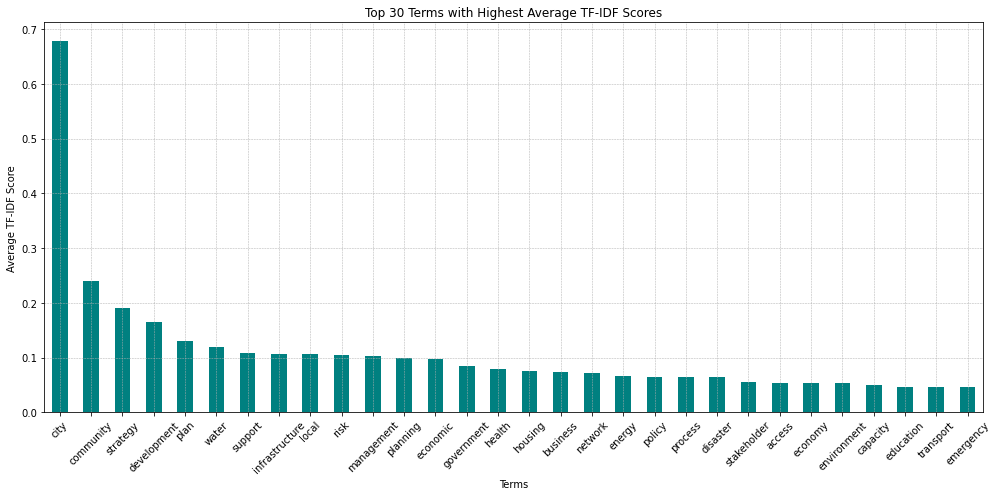

In [17]:
# Load the TF-IDF scores from the CSV file again
tfidf_data = pd.read_csv("TFIDF_Scores.csv")

# Calculate the average TF-IDF scores for each term again
average_tfidf_scores = tfidf_data.drop("City", axis=1).mean().sort_values(ascending=False)

# Extract the top 10 terms with the highest average scores again
top_10_avg_tfidf = average_tfidf_scores.head(30)

# Plot the top 10 terms again
plt.figure(figsize=(14, 7))
top_10_avg_tfidf.plot(kind='bar', color='teal')
plt.title('Top 30 Terms with Highest Average TF-IDF Scores')
plt.xlabel('Terms')
plt.ylabel('Average TF-IDF Score')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()